In [1]:
##imports and setup
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


#mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setting up gpu..
MIXED_PRECISION = True
XLA_ACCELERATE = False  # Didn't work; Dunno Why!

GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
  try:
    for GPU in GPUS:
      tf.config.experimental.set_memory_growth(GPU, True)
      logical_gpus = tf.config.experimental.list_logical_devices('GPU')
      print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as  RE:
    print(RE)

if MIXED_PRECISION:
  policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
  tf.keras.mixed_precision.experimental.set_policy(policy)
  print('Mixed precision enabled')

if XLA_ACCELERATE:
  tf.config.optimizer.set_jit(True)
  print('Accelerated Linear Algebra enabled')

print("Tensorflow version " + tf.__version__)

print('completed')

1 Physical GPUs, 1 Logical GPUs
Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Mixed precision enabled
Tensorflow version 2.4.1
completed


In [ ]:
#prepare train and validation data:


# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/emotic'

# Load training preprocessed data
#only considering the valence and arousal...
#train_context = np.load(data_src+'/train_context_arr.npy')
train_body = np.load(data_src+'/train_body_arr.npy')
#train_cat = np.load(data_src+'/train_cat_arr.npy')
train_cont = np.load(data_src+'/train_cont_arr.npy')
train_cont = train_cont[:,:2]/10

# Load validation preprocessed data 
#val_context = np.load(data_src+'/val_context_arr.npy')
#val_body = np.load(data_src+'/val_body_arr.npy')
#val_cat = np.load(data_src+'/val_cat_arr.npy')
#val_cont = np.load(data_src+'/val_cont_arr.npy')
#val_cont = val_cont[:,:2]/10

# Load testing preprocessed data
#test_context = np.load(data_src+'/test_context_arr.npy')
#test_body = np.load(data_src+'/test_cat_arr.npy')
#test_cat = np.load(data_src+'/test_cat_arr.npy')
#test_cont = np.load(data_src+'/test_cont_arr.npy')
#test_cont = test_cont[:,:2]/10

print ('train ', 'body', train_body.shape, 'cont', train_cont.shape)
#print ('val ', 'body', val_body.shape, 'cont', val_cont.shape)
#print ('test ', 'body', test_body.shape, 'cont', test_cont.shape)
print ('completed cell')

train  body (23266, 128, 128, 3) cont (23266, 2)
completed cell


In [ ]:
batch_size=64
### Fit the emotic dataset:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  validation_split=0.2,
                                  horizontal_flip=True)
train_datagen.fit(train_body)

training_set=train_datagen.flow(train_body,train_cont,batch_size=batch_size,shuffle=True,subset='training')
#training_set = NumpyArrayIterator(train_body,train_cont,train_datagen,batch_size=52)

#val_datagen = ImageDataGenerator(rescale=1./255,
#                                horizontal_flip=True)
val_set=train_datagen.flow(train_body,train_cont,batch_size=batch_size,shuffle=True,subset='validation')
#val_set = NumpyArrayIterator(val_body,val_cont,val_datagen,batch_size=52)
print(training_set)
print('completed')

completed


In [ ]:
### model setup
#data size 128
IMG_SIZE = 128

def model_vgg13_custom( output_classes=2):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Faltten the model
    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    #Sigmoid Activation function
    model.add(Dense(output_classes, activation='sigmoid'))
    opt = Adam(lr=0.0001, decay=1e-6)
    #Mean Squared Error loss function
    model.compile(optimizer=opt, loss='MSE', metrics=['accuracy'])
    print(model.summary())
    return model
model=model_vgg13_custom()
print('completed')

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
___________________________________________________

In [ ]:
###making the training ready
chk_path = '/models/model_vgg.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = training_set.n // training_set.batch_size# forced to 100 for now
validation_steps = val_set.n // val_set.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

print('completed')

290
72
completed


In [ ]:
#Fejlen kommer uanset om validation settet er med eller ej... Det er enten training settet der bliver lavet forkert eller også er det modellen der ikke passer til training settet...
tf.device('/device:GPU:0')
epochs=40
model_hist = model.fit(x=training_set,
                 validation_data=val_set,
                 epochs=epochs,
                 callbacks=callback,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)
model.save_weights('model_vgg_emotic.h5')

Epoch 1/40
290/290 [==============================] - 184s 514ms/step - loss: 0.0747 - accuracy: 0.5366 - val_loss: 0.0388 - val_accuracy: 0.6578

Epoch 00001: val_loss improved from inf to 0.03883, saving model to /models/model_vgg.h5
Epoch 2/40
290/290 [==============================] - 145s 498ms/step - loss: 0.0458 - accuracy: 0.5733 - val_loss: 0.0356 - val_accuracy: 0.6578

Epoch 00002: val_loss improved from 0.03883 to 0.03556, saving model to /models/model_vgg.h5
Epoch 3/40
290/290 [==============================] - 144s 497ms/step - loss: 0.0424 - accuracy: 0.5947 - val_loss: 0.0341 - val_accuracy: 0.6547

Epoch 00003: val_loss improved from 0.03556 to 0.03410, saving model to /models/model_vgg.h5
Epoch 4/40
290/290 [==============================] - 143s 493ms/step - loss: 0.0399 - accuracy: 0.6107 - val_loss: 0.0337 - val_accuracy: 0.6608

Epoch 00004: val_loss improved from 0.03410 to 0.03374, saving model to /models/model_vgg.h5
Epoch 5/40
290/290 [========================

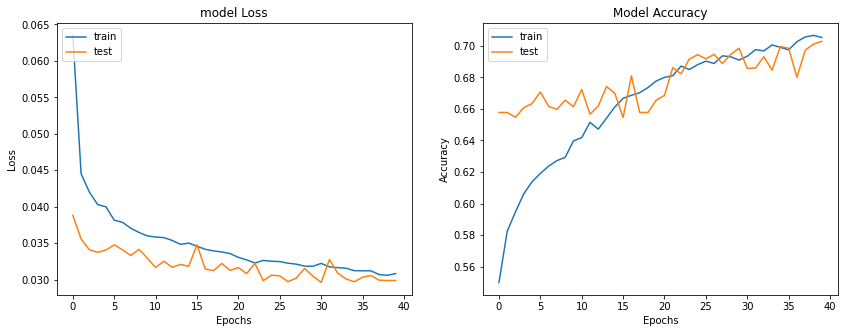

<Figure size 432x288 with 0 Axes>

In [ ]:

###Results for the model
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("test_accuracy_loss.png")


In [ ]:
import cv2
import dlib
from imutils import face_utils
from PIL import Image
from google.colab.patches import cv2_imshow

#extracting face and body and outputs tensor
def extract_face_and_body(frame):#add size of output image
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  #extract ROIS
  for (x,y,w,h) in faces:
    #cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    ##simple scalings...
    temp=y-int(h/3)
    if y-int(h/3) <0:
      temp=0
    roi = frame[temp:y+h*2, x-1*w:x+2*w]
  dim=(128,128)
  resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
  #print(resized.shape)
  cv2_imshow(frame)
  print(resized.shape)
  #pil_img = Image.fromarray(resized).convert('RGB')

  #image_tensor = transforms.ToTensor()(pil_img).unsqueeze(0)
  return resized[None,...]/255
print('completed')

completed


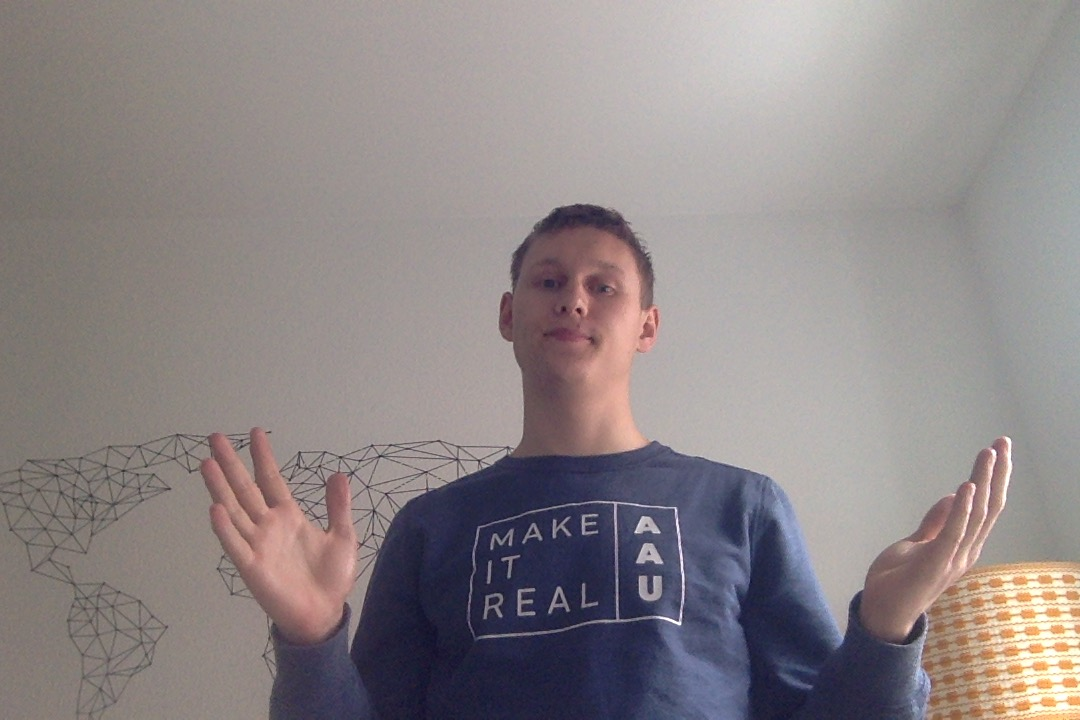

(128, 128, 3)
[[0.622  0.6206]]
completed cell


In [ ]:
PATH = '/content/drive/MyDrive/Colab/emotion_pics/'
#print(image)
#print(img.shape)
#print(type(img))
#pred=model_predict(img[None,...])


frame = cv2.imread(PATH + 'body.jpg')
arr=extract_face_and_body(frame)
#image_tensor = extract_face_and_body(frame)
#print(arr[None,...]/255)
predi=model.predict(arr)

#_,con=cont_predict(predi)
print(predi)
print('completed cell')
